In [1]:
import torch
from torch.distributions import Bernoulli
from torch.autograd import Variable
import numpy as np

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class MLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim = 36):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [4]:
class PolicyGradient:
    
    def __init__(self, state_dim,cfg):
        self.gamma = cfg.gamma
        self.policy_net = MLP(state_dim,hidden_dim=cfg.hidden_dim)
        self.optimizer = torch.optim.RMSprop(self.policy_net.parameters(), lr=cfg.lr)
        self.batch_size = cfg.batch_size
    
    def choose_action(self,state):
        state = torch.from_numpy(state).float()
        state = Variable(state)
        probs = self.policy_net(state)
        m = Bernoulli(probs) # 伯努利分布
        action = m.sample()
        action = action.data.numpy().astype(int)[0] # 转为标量
        return action
    
    def update(self,reward_pool,state_pool,action_pool):
        # Discount reward
        running_add = 0
        for i in reversed(range(len(reward_pool))):
            if reward_pool[i] == 0:
                running_add = 0
            else:
                running_add = running_add * self.gamma + reward_pool[i]  # 第i个元素表示当前时间步下，对未来的累积奖励
                reward_pool[i] = running_add

        # Normalize reward
        reward_mean = np.mean(reward_pool)
        reward_std = np.std(reward_pool)
        for i in range(len(reward_pool)):
            reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

        # Gradient Desent
        self.optimizer.zero_grad()

        for i in range(len(reward_pool)):
            state = state_pool[i]
            action = Variable(torch.FloatTensor([action_pool[i]]))
            reward = reward_pool[i]
            state = Variable(torch.from_numpy(state).float())
            probs = self.policy_net(state)
            m = Bernoulli(probs)
            loss = -m.log_prob(action) * reward  # Negtive score function x reward
            # m.log_prob(action)相当于probs.log()[0][action.item()].unsqueeze(0), 
            # probs为神经网络的输出概率， action为真实的概率，这里相当于做交叉熵，而在策略梯度问题中，还需乘上一个reward
            # 加负号是因为这里使用梯度上升，而loss一般是使用梯度下降
            # print(loss)
            loss.backward()
        self.optimizer.step()

In [5]:
import sys,os
curr_path = os.path.dirname(os.path.realpath('__file__')) # 当前文件所在绝对路径
parent_path = os.path.dirname(curr_path) # 父路径
sys.path.append(parent_path) # 添加父路径到系统路径sys.path

import gym
import torch
import datetime
from itertools import count

from common.utils import save_results,make_dir, plot_rewards

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [29]:
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # 获取当前时间

class PGConfig:
    def __init__(self):
        self.algo_name = "PolicyGradient"  # 算法名称
        self.env_name = 'CartPole-v1' # 环境名称
        self.result_path = curr_path+"/outputs/" + self.env_name + '/'+curr_time+'/results/'  # 保存结果的路径
        self.model_path = curr_path+"/outputs/" + self.env_name + '/'+curr_time+'/models/'  # 保存模型的路径
        self.train_eps = 300 # 训练的回合数
        self.test_eps = 30 # 测试的回合数
        self.batch_size = 8
        self.lr = 0.01 # 学习率
        self.gamma = 0.99
        self.hidden_dim = 36 # dimmension of hidden layer
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")  # check gpu
        self.save = False

In [30]:
def env_agent_config(cfg,seed=1):
    env = gym.make(cfg.env_name)  
    env.seed(seed)
    state_dim = env.observation_space.shape[0]
    agent = PolicyGradient(state_dim,cfg)
    return env,agent

In [31]:
def train(cfg,env,agent):
    print('Start to eval !')
    print(f'Env:{cfg.env_name}, Algorithm:{cfg.algo_name}, Device:{cfg.device}')
    state_pool = [] # 存放每batch_size个episode的state序列
    action_pool = []
    reward_pool = [] 
    rewards = []
    ma_rewards = []
    for i_ep in range(cfg.train_eps):
        state = env.reset()
        ep_reward = 0
        for _ in count():
            action = agent.choose_action(state) # 根据当前环境state选择action
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            if done:
                reward = 0
            state_pool.append(state)
            action_pool.append(float(action))
            reward_pool.append(reward)
            state = next_state
            if done:
                print('Episode:', i_ep, ' Reward:',  ep_reward)
                break
        if i_ep > 0 and i_ep % cfg.batch_size == 0:
            agent.update(reward_pool,state_pool,action_pool)
            state_pool = [] # 每个episode的state
            action_pool = []
            reward_pool = []
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(
                0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
    print('complete training！')
    return rewards, ma_rewards

In [25]:
def eval(cfg,env,agent):
    print('Start to eval !')
    print(f'Env:{cfg.env_name}, Algorithm:{cfg.algo_name}, Device:{cfg.device}')
    rewards = []
    ma_rewards = []
    for i_ep in range(cfg.test_eps):
        state = env.reset()
        ep_reward = 0
        for _ in count():
            action = agent.choose_action(state) # 根据当前环境state选择action
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            if done:
                reward = 0
            state = next_state
            if done:
                print('Episode:', i_ep, ' Reward:',  ep_reward)
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(
                0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
    print('complete evaling！')
    return rewards, ma_rewards

In [33]:
cfg = PGConfig()
env, agent = env_agent_config(cfg, seed=1)

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\gym\core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


In [27]:
rewards, ma_rewards = train(cfg, env, agent)

Start to eval !
Env:CartPole-v1, Algorithm:PolicyGradient, Device:cuda
Episode: 0  Reward: 17.0
Episode: 1  Reward: 27.0
Episode: 2  Reward: 12.0
Episode: 3  Reward: 36.0
Episode: 4  Reward: 9.0
Episode: 5  Reward: 15.0


D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Episode: 6  Reward: 27.0
Episode: 7  Reward: 24.0
Episode: 8  Reward: 21.0
Episode: 9  Reward: 23.0
Episode: 10  Reward: 47.0
Episode: 11  Reward: 10.0
Episode: 12  Reward: 15.0
Episode: 13  Reward: 13.0
Episode: 14  Reward: 12.0
Episode: 15  Reward: 16.0
Episode: 16  Reward: 36.0
Episode: 17  Reward: 9.0
Episode: 18  Reward: 12.0
Episode: 19  Reward: 15.0
Episode: 20  Reward: 16.0
Episode: 21  Reward: 12.0
Episode: 22  Reward: 10.0
Episode: 23  Reward: 20.0
Episode: 24  Reward: 36.0
Episode: 25  Reward: 39.0
Episode: 26  Reward: 10.0
Episode: 27  Reward: 67.0
Episode: 28  Reward: 47.0
Episode: 29  Reward: 46.0
Episode: 30  Reward: 15.0
Episode: 31  Reward: 19.0
Episode: 32  Reward: 31.0
Episode: 33  Reward: 27.0
Episode: 34  Reward: 35.0
Episode: 35  Reward: 32.0
Episode: 36  Reward: 30.0
Episode: 37  Reward: 23.0
Episode: 38  Reward: 23.0
Episode: 39  Reward: 31.0
Episode: 40  Reward: 15.0
Episode: 41  Reward: 52.0
Episode: 42  Reward: 30.0
Episode: 43  Reward: 37.0
Episode: 44  Rewa

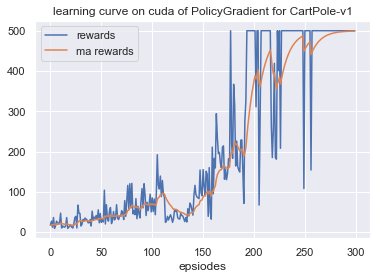

In [36]:
plot_rewards(rewards, ma_rewards, cfg)

Start to eval !
Env:CartPole-v1, Algorithm:PolicyGradient, Device:cuda
Episode: 0  Reward: 25.0
Episode: 1  Reward: 16.0
Episode: 2  Reward: 16.0
Episode: 3  Reward: 44.0
Episode: 4  Reward: 21.0
Episode: 5  Reward: 73.0
Episode: 6  Reward: 11.0
Episode: 7  Reward: 17.0
Episode: 8  Reward: 21.0
Episode: 9  Reward: 12.0
Episode: 10  Reward: 17.0
Episode: 11  Reward: 22.0
Episode: 12  Reward: 41.0
Episode: 13  Reward: 13.0
Episode: 14  Reward: 16.0
Episode: 15  Reward: 12.0
Episode: 16  Reward: 13.0
Episode: 17  Reward: 15.0
Episode: 18  Reward: 18.0
Episode: 19  Reward: 19.0
Episode: 20  Reward: 21.0
Episode: 21  Reward: 12.0
Episode: 22  Reward: 19.0
Episode: 23  Reward: 18.0
Episode: 24  Reward: 15.0
Episode: 25  Reward: 23.0
Episode: 26  Reward: 27.0
Episode: 27  Reward: 19.0
Episode: 28  Reward: 23.0
Episode: 29  Reward: 15.0
complete evaling！


D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


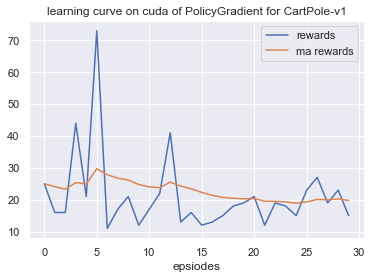

In [37]:
rewards,ma_rewards = eval(cfg,env,agent)
plot_rewards(rewards,ma_rewards, cfg, tag="eval")